# 环境配置

conda install -c conda-forge opencv

# 模块读取

In [1]:
import cv2

In [2]:
import os
import sys
import json

In [3]:
import numpy as np

In [4]:
from IPython.display import Image

In [6]:
import matplotlib.pyplot as plt

# 数据下载

In [7]:
sys.executable # 查看当前的python运行环境

'/home/zwl/miniconda3/envs/cv/bin/python'

In [8]:
os.listdir()

['mchar_test_a',
 'README.md',
 'mchar_val',
 '.ipynb_checkpoints',
 'download.sh',
 'mchar_sample_submit_A.csv',
 'mchar_train.json',
 '__MACOSX',
 'mchar_val.json',
 'mchar_data_list_0515.csv',
 'eda.ipynb',
 'mchar_train',
 'unzip.sh']

In [9]:
train_json = json.load(open('mchar_train.json'))

In [10]:
train_json['000000.png']

{'height': [219, 219],
 'label': [1, 9],
 'left': [246, 323],
 'top': [77, 81],
 'width': [81, 96]}

In [11]:
count = 5 # 这里只显示打印5张照片
for pic, data in train_json.items():
    if count == 0:
        break
    print(pic)
    print(data)
    count -= 1

000000.png
{'height': [219, 219], 'label': [1, 9], 'left': [246, 323], 'top': [77, 81], 'width': [81, 96]}
000001.png
{'height': [32, 32], 'label': [2, 3], 'left': [77, 98], 'top': [29, 25], 'width': [23, 26]}
000002.png
{'height': [15, 15], 'label': [2, 5], 'left': [17, 25], 'top': [5, 5], 'width': [8, 9]}
000003.png
{'height': [34, 34], 'label': [9, 3], 'left': [57, 72], 'top': [13, 13], 'width': [15, 13]}
000004.png
{'height': [46, 46], 'label': [3, 1], 'left': [52, 74], 'top': [7, 10], 'width': [21, 15]}


In [12]:
def parse_json(d):
    res = np.array([
        d['top'], d['height'], d['left'], d['width'], d['label']
    ])
    res = res.astype(int)
    return res

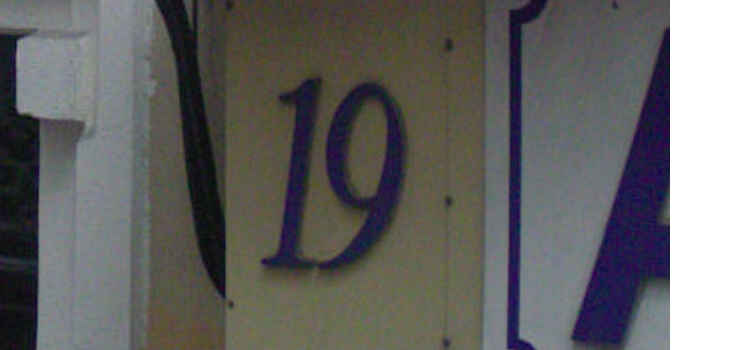

In [13]:
Image('mchar_train/000000.png')

In [14]:
img = cv2.imread('mchar_train/000000.png')
arr = parse_json(train_json['000000.png'])

In [15]:
arr # 矩阵的列数为图片中的数字数

array([[ 77,  81],
       [219, 219],
       [246, 323],
       [ 81,  96],
       [  1,   9]])

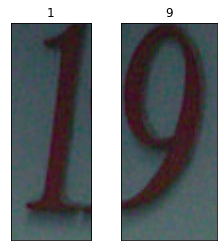

In [16]:
for idx in range(arr.shape[1]):
    plt.subplot(1, arr.shape[1]+1, idx+2)
    plt.imshow(img[arr[0, idx]:arr[0, idx]+arr[1, idx],arr[2, idx]:arr[2, idx]+arr[3, idx]])
    plt.title(arr[4, idx])
    plt.xticks([]); plt.yticks([])

# 赛题思路分析

- 定长字符数据识别
- 先检查下数据集中字符最长的标签有多长

In [87]:
train_json = json.load(open('mchar_train.json'))
max_len = 0
for img_name in os.listdir('mchar_train/'):
   max_len = max(max_len, len(train_json[img_name]['label']))
print(max_len)

6


In [88]:
val_json = json.load(open('mchar_val.json'))
max_len = 0
for img_name in os.listdir('mchar_val/'):
   max_len = max(max_len, len(val_json[img_name]['label']))
print(max_len)

5


训练集中，图片数字字符最长有6， 测试集中最长数字字符有5，该题思路可以看成定长字符数据识别：

也就是本来是1,2.因为最长字符有6.所以看成，1，2，x，x，x，x。每个位置看成一个分类问题。每个位置的类别为11, 0-9 一共10，还有x.这里使用数字10来代替x。表示该位置是空着的。

# 数据读取与扩增

- 数据扩增有什么用？

    可以增大数据集，训练的时候可以有效防止过拟合。

- 有哪些数据扩增的方法？

    在数据扩增方法中，一般会从图像颜色，尺寸，形态，空间和像素等角度进行变换。可以多种变换方法相互组合。

    对于图像分类：数据扩增一般不会改变标签

    对于物体检测：数据扩增会改变物体坐标位置

    这些扩增都很符合直觉。

    使用：torchvision 模块中的 transforms函数进行变换，可以直接调用。

In [22]:
# 图像处理中很重要的几个库
from PIL import Image
import cv2

In [19]:
os.listdir()

['mchar_test_a',
 'README.md',
 'mchar_val',
 '.ipynb_checkpoints',
 'download.sh',
 'mchar_sample_submit_A.csv',
 'mchar_train.json',
 '__MACOSX',
 'mchar_val.json',
 'mchar_data_list_0515.csv',
 'eda.ipynb',
 'mchar_train',
 'unzip.sh']

首先介绍下这几个文件是干什么的：

- mchar_val:image path
- mchar_val.json:validation image label
- mchar_train:train image path
- mchar_train.json: train image label

首先构造数据集，pytorch中数据集是先用dataset构造，然后用dataloader来装载数据集进行训练。

In [50]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

In [101]:
# 首先构建my dataset，这个类对象中一定要有三个魔法方法，init， getitem，len
class Mydataset(Dataset):
    def __init__(self, img_path, json_path, transform=True):
        self.img_path = img_path
        self.json_path = json_path
        self.transform = transform
        if self.transform:
            self.transforms = transforms.Compose([
              # 缩放到固定尺寸
              transforms.Resize((64, 128)),
              # 随机颜色变换
              transforms.ColorJitter(0.2, 0.2, 0.2),
              # 加入随机旋转
              transforms.RandomRotation(5),
              # 将图片转换为pytorch 的tesntor
              transforms.ToTensor(),
              # 对图像像素进行归一化
              transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
            ])
        # get json data
        self.img_json = json.load(open(self.json_path))
        # get imge name list
        self.img_list = sorted(os.listdir(self.img_path))
    def __getitem__(self, idx):
        img_name = self.img_list[idx]
        img = Image.open(self.img_path + '/' + img_name).convert('RGB')
        if self.transform:
            img = self.transforms(img)
        label = self.img_json[img_name]['label']
        label += (6-len(label))*[10]
        # 将label转换成tensor
        label = torch.tensor(np.array(label)).long()
        return img, label
    def __len__(self):
        return len(self.img_list)

In [102]:
train_dataset = Mydataset('./mchar_train', './mchar_train.json')
val_dataset = Mydataset('./mchar_val', './mchar_val.json')

In [103]:
len(train_dataset), len(val_dataset)

(30000, 10000)

In [104]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=10)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=10)

In [105]:
# 检查下构造的数据和标签
for feature, label in train_loader:
    print(feature.shape)
    print(label.shape)
    break

torch.Size([10, 3, 64, 128])
torch.Size([10, 6])


# CNN模型构建

官方baseline：https://tianchi.aliyun.com/notebook-ai/detail?postId=108342

## CNN模型的使用

In [106]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import random

In [107]:
# 固定随机数种子
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [152]:
class cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((3, 3)),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((3, 3)),
        )
        self.fc1 = nn.Linear(32*3*3, 11)
        self.fc2 = nn.Linear(32*3*3, 11)
        self.fc3 = nn.Linear(32*3*3, 11)
        self.fc4 = nn.Linear(32*3*3, 11)
        self.fc5 = nn.Linear(32*3*3, 11)
        self.fc6 = nn.Linear(32*3*3, 11)
    def forward(self, img):
        x = self.cnn(img)
        x = x.reshape(x.shape[0], -1)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        x4 = self.fc4(x)
        x5 = self.fc5(x)
        x6 = self.fc6(x)
        return x1, x2, x3, x4, x5, x6

In [180]:
model = cnn()
epochs = 50
lr = 0.0001
gamma = 0.9
step_size=5

device_count = torch.cuda.device_count()
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda:0" if USE_CUDA else "cpu")

if device_count > 1:
    model = nn.DataParallel(model,device_ids=range(device_count)) # multi-GPU
    model.to(device)

else:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma) # 学习方式

In [181]:
# 要这个图片中的所有数字都识别对了，才算这个图片识别正确。
def get_acc(x1, x2, x3, x4, x5, x6, label):
    res1 = x1.argmax(dim=1).eq(label[:, 0])
    res2 = x2.argmax(dim=1).eq(label[:, 1])
    res3 = x3.argmax(dim=1).eq(label[:, 2])
    res4 = x4.argmax(dim=1).eq(label[:, 3])
    res5 = x5.argmax(dim=1).eq(label[:, 4])
    res6 = x6.argmax(dim=1).eq(label[:, 5])
#    res = res1 & res2 & res3 & res4 & res5 & res6
    res = res1
    return res.sum().item()

In [182]:
from tqdm import tqdm

In [ ]:
# strat training 
total_loss = []
train_acc = []
val_acc = []

for epoch in range(epochs):
    model.train()
    
    train_total_acc = 0
    val_total_acc = 0
    
    for feature, label in tqdm(train_loader):
        feature = feature.cuda()
        label = label.cuda()
        x1, x2, x3, x4, x5, x6 = model(feature)
        train_total_acc += get_acc(x1, x2, x3, x4, x5, x6, label)
        loss = criterion(x1, label[:, 0]) + \
        criterion(x2, label[:, 1]) + \
        criterion(x3, label[:, 2]) + \
        criterion(x4, label[:, 3]) + \
        criterion(x5, label[:, 4]) + \
        criterion(x5, label[:, 5])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_acc.append(train_total_acc/len(train_dataset))
    
    
    model.eval()        
    with torch.no_grad():
        for feature, label in tqdm(val_loader):
            feature = feature.cuda()
            label = label.cuda()
            x1, x2, x3, x4, x5, x6 = model(feature)
            val_total_acc += get_acc(x1, x2, x3, x4, x5, x6, label)
        val_acc.append(val_total_acc/len(val_dataset))
        
    print(f'EPOCH:{epoch}, loss:{loss}, train_acc:{train_acc[epoch]}, val_acc:{val_acc[epoch]}')  
            

  0%|          | 5/3000 [00:00<01:08, 43.96it/s]

EPOCH:0, loss:5.117116451263428, train_acc:0.2743, val_acc:0.2819


  0%|          | 5/3000 [00:00<01:04, 46.43it/s]

EPOCH:1, loss:5.74662446975708, train_acc:0.27613333333333334, val_acc:0.2819


  0%|          | 5/3000 [00:00<01:02, 48.02it/s]

EPOCH:2, loss:6.609799861907959, train_acc:0.2764, val_acc:0.2819


  0%|          | 5/3000 [00:00<01:05, 45.48it/s]

EPOCH:3, loss:6.396030426025391, train_acc:0.27623333333333333, val_acc:0.2819


  0%|          | 5/3000 [00:00<01:06, 44.86it/s]

EPOCH:4, loss:6.368590831756592, train_acc:0.2764, val_acc:0.2819


  0%|          | 5/3000 [00:00<01:09, 42.87it/s]

EPOCH:5, loss:6.009864330291748, train_acc:0.2764, val_acc:0.2816


  0%|          | 5/3000 [00:00<01:04, 46.23it/s]

EPOCH:6, loss:6.101135730743408, train_acc:0.2761, val_acc:0.2819


 90%|█████████ | 2702/3000 [00:57<00:06, 45.97it/s]

In [190]:
# 代码优化，可以将训练和验证写成两个函数，这样美观又直接
def model_train(model, train_loader, train_acc, train_dataset, criterion):
    model.train()
    train_total_acc = 0
    for feature, label in tqdm(train_loader):
        feature = feature.cuda()
        label = label.cuda()
        x1, x2, x3, x4, x5, x6 = model(feature)
        train_total_acc += get_acc(x1, x2, x3, x4, x5, x6, label)
        loss = criterion(x1, label[:, 0]) + \
        criterion(x2, label[:, 1]) + \
        criterion(x3, label[:, 2]) + \
        criterion(x4, label[:, 3]) + \
        criterion(x5, label[:, 4]) + \
        criterion(x5, label[:, 5])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    total_loss.append(loss)
    train_acc.append(train_total_acc/len(train_dataset)) 

In [191]:
def model_val(model, val_loader, val_acc, val_dataset):
    model.eval()        
    val_total_acc = 0
    with torch.no_grad():
        for feature, label in tqdm(val_loader):
            feature = feature.cuda()
            label = label.cuda()
            x1, x2, x3, x4, x5, x6 = model(feature)
            val_total_acc += get_acc(x1, x2, x3, x4, x5, x6, label)
        val_acc.append(val_total_acc/len(val_dataset))

## 保存最佳权重并加载

In [192]:
# strat training 
total_loss = []
train_acc = []
val_acc = []

train_best = 1000
for epoch in range(epochs):
    model_train(model, train_loader, train_acc, train_dataset, criterion,)
    model_val(model, val_loader, val_acc, val_dataset) 
    print(f'EPOCH:{epoch}, loss:{total_loss[epoch]}, train_acc:{train_acc[epoch]}, val_acc:{val_acc[epoch]}')  
    # 保存最佳权重
    if total_loss[epoch] < train_best:
        train_best = total_loss[epoch]
        torch.save(model.state_dict(), './model.point')

  0%|          | 5/3000 [00:00<01:11, 42.07it/s]

EPOCH:0, loss:4.288761138916016, train_acc:0.28073333333333333, val_acc:0.2777


  0%|          | 5/3000 [00:00<01:08, 43.64it/s]

EPOCH:1, loss:4.953968048095703, train_acc:0.28073333333333333, val_acc:0.278


  0%|          | 5/3000 [00:00<01:09, 43.12it/s]

EPOCH:2, loss:4.8972954750061035, train_acc:0.2816666666666667, val_acc:0.2791


  0%|          | 5/3000 [00:00<01:10, 42.63it/s]

EPOCH:3, loss:5.271100997924805, train_acc:0.2807, val_acc:0.2786


  0%|          | 5/3000 [00:00<01:07, 44.68it/s]

EPOCH:4, loss:4.895415306091309, train_acc:0.2836, val_acc:0.2798


  0%|          | 5/3000 [00:00<01:11, 42.07it/s]

EPOCH:5, loss:4.7714152336120605, train_acc:0.2828, val_acc:0.2768


  0%|          | 5/3000 [00:00<01:07, 44.61it/s]

EPOCH:6, loss:4.189699649810791, train_acc:0.2816666666666667, val_acc:0.2746


  0%|          | 5/3000 [00:00<01:01, 48.35it/s]

EPOCH:7, loss:5.126197338104248, train_acc:0.28103333333333336, val_acc:0.279


  0%|          | 5/3000 [00:00<01:03, 46.98it/s]

EPOCH:8, loss:6.120145797729492, train_acc:0.2821, val_acc:0.2745


 79%|███████▉  | 2364/3000 [00:50<00:13, 47.16it/s]


KeyboardInterrupt: 

In [193]:
# 读取模型权重
model.load_state_dict(torch.load('model.point')) 

<All keys matched successfully>

## 加入dropout

dropout相当于机器学习中的集成学习,本质是随机丢弃一些神经元，其实相当于每次随机使用一些属性进行训练。这样能有效防止过你和。在测试的时候，神经元不进行丢弃，所有神经元都使用。

In [207]:
# 加入dropout后的神经网络
class cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.AdaptiveAvgPool2d((3, 3)),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.AdaptiveAvgPool2d((3, 3)),
        )
        self.fc1 = nn.Linear(32*3*3, 11)
        self.fc2 = nn.Linear(32*3*3, 11)
        self.fc3 = nn.Linear(32*3*3, 11)
        self.fc4 = nn.Linear(32*3*3, 11)
        self.fc5 = nn.Linear(32*3*3, 11)
        self.fc6 = nn.Linear(32*3*3, 11)
    def forward(self, img):
        x = self.cnn(img)
        x = x.reshape(x.shape[0], -1)
        print(x.shape[0])
        assert 0
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        x4 = self.fc4(x)
        x5 = self.fc5(x)
        x6 = self.fc6(x)
        return x1, x2, x3, x4, x5, x6

# Resnet模型构建

这里改进为resnet18, 可以用resnet18前面的卷积来进行特征提取。使用线性层来进行分类。

## Resnet18

In [208]:
import torchvision.models as models

In [249]:
class Resnet(nn.Module):
    def __init__(self):
        super().__init__()
        # 调用resnet18模型
        conv_model = models.resnet18(pretrained=True)
        # 修改为自适应
        # conv_model.argpool = nn.AdaptiveAvgPool2d(1)
        # 不要最后一层
        self.cnn = nn.Sequential(*list(conv_model.children())[:-1])
        
        self.fc1 = nn.Linear(512, 11)
        self.fc2 = nn.Linear(512, 11)
        self.fc3 = nn.Linear(512, 11)
        self.fc4 = nn.Linear(512, 11)
        self.fc5 = nn.Linear(512, 11)
        self.fc6 = nn.Linear(512, 11)
        
    def forward(self, img):
        x = self.cnn(img)
        x = x.reshape(x.shape[0], -1)
        x1 = self.fc1(x)
        x2 = self.fc2(x)
        x3 = self.fc3(x)
        x4 = self.fc4(x)
        x5 = self.fc5(x)
        x6 = self.fc6(x)
        return x1, x2, x3, x4, x5, x6

In [250]:
model = Resnet()
epochs = 50
lr = 0.0001
gamma = 0.9
step_size=5

device_count = torch.cuda.device_count()
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda:0" if USE_CUDA else "cpu")

if device_count > 1:
    model = nn.DataParallel(model,device_ids=range(device_count)) # multi-GPU
    model.to(device)

else:
    model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma) # 学习方式

In [251]:
# strat training 
total_loss = []
train_acc = []
val_acc = []

train_best = 1000
for epoch in range(epochs):
    model_train(model, train_loader, train_acc, train_dataset, criterion,)
    model_val(model, val_loader, val_acc, val_dataset) 
    print(f'EPOCH:{epoch}, loss:{total_loss[epoch]}, train_acc:{train_acc[epoch]}, val_acc:{val_acc[epoch]}')  
    # 保存最佳权重
    if total_loss[epoch] < train_best:
        train_best = total_loss[epoch]
        torch.save(model.state_dict(), './model.point')

  0%|          | 0/3000 [00:00<?, ?it/s]

EPOCH:0, loss:2.3890540599823, train_acc:0.6468666666666667, val_acc:0.629


  0%|          | 0/3000 [00:00<?, ?it/s]

EPOCH:1, loss:2.2496731281280518, train_acc:0.8116, val_acc:0.6657


  0%|          | 0/3000 [00:00<?, ?it/s]

EPOCH:2, loss:1.4398047924041748, train_acc:0.8479, val_acc:0.6947


  0%|          | 0/3000 [00:00<?, ?it/s]

EPOCH:3, loss:0.9909995198249817, train_acc:0.8777666666666667, val_acc:0.6965


 10%|▉         | 294/3000 [00:10<01:40, 26.84it/s]


KeyboardInterrupt: 

# TODO

- [ ] 学习tta，测试集训练三次取平均https://tianchi.aliyun.com/notebook-ai/detail?spm=5176.12586969.1002.18.2ce823e6FF4FLX&postId=108656
- [ ] 看下官方的baseline：https://tianchi.aliyun.com/notebook-ai/detail?postId=108342